# Analyse de Robustesse et Comparaison d'Imputation

Ce notebook est structuré pour entraîner un encodeur TS2VEC sur des séries temporelles, évaluer sa robustesse face aux données manquantes, et comparer ses performances avec des méthodes d'imputation classiques en classifiant avec un SVM.

## Importations et Hyperparamètres

In [82]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F


import models as m

from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import torch.optim as optim

# HYPERPARAM
REP_DIM = 320
NUM_BLOCKS = 10
KERNEL_SIZE = 3
LR = 1e-4
N_EPOCH = 30 
ALPHA_HIER = 0.5
BATCH_SIZE = 16


CLASS_NAMES = {
    1: "Fridge/Freezer",
    2: "Refrigerator",
    3: "Upright Freezer",
}

## Donnée, Encodeur et Classifieur

### Simulation de données manquantes et Traitement des données

In [83]:
def load_data(PREPROCESS=True):
    """Load and prepare data from dataset."""
    CURR_DIR = Path.cwd()
    # Si le notebook est dans un sous-dossier, ajustez ici (ex: CURR_DIR.parents[0])
    SRC_DIR = CURR_DIR.parents[0]
    
    DATA_DIR = SRC_DIR / "data"
    DATASET_DIR = DATA_DIR / "RefrigerationDevices"
    train_path = DATASET_DIR / "RefrigerationDevices_TRAIN.ts"
    test_path = DATASET_DIR / "RefrigerationDevices_TEST.ts"
    
    if not PREPROCESS:
        print("using NOT preprocessed data")
        X_train_df, y_train_arr = load_from_tsfile_to_dataframe(str(train_path))
        X_test_df, y_test_arr = load_from_tsfile_to_dataframe(str(test_path))
        
        def df_to_numpy(X_df):
            arr = np.stack([X_df.iloc[i, 0] for i in range(len(X_df))], axis=0)
            return arr[..., np.newaxis]
        
        X_train_np = df_to_numpy(X_train_df)
        X_test_np = df_to_numpy(X_test_df)
        y_train_np = np.asarray(y_train_arr, dtype=np.int64)
        y_test_np = np.asarray(y_test_arr, dtype=np.int64)
    else:
        print("using PREPROCESSED data")
        PREP_DIR = DATASET_DIR / "preprocessed"
        train_npz_path = PREP_DIR / "RefrigerationDevices_TRAIN_preprocessed.npz"
        test_npz_path = PREP_DIR / "RefrigerationDevices_TEST_preprocessed.npz"
        
        train_data = np.load(train_npz_path)
        test_data = np.load(test_npz_path)
        
        X_train_np = train_data["X"]
        y_train_np = train_data["y"].astype(np.int64)
        X_test_np = test_data["X"]
        y_test_np = test_data["y"].astype(np.int64)
    
    print("X_train_np shape:", X_train_np.shape)
    print("X_test_np shape:", X_test_np.shape)
    
    return X_train_np, y_train_np, X_test_np, y_test_np

In [84]:
def inject_missing_values_random_noise(x, ratio):
    """
    Simule des valeurs manquantes ponctuelles en remplaçant une fraction aléatoire
    des données par du bruit aléatoire (NaN).
    """
    if ratio <= 0:
        return x
    
    mask = torch.rand_like(x) > ratio
    noise = torch.full_like(x, float('nan'))
    return torch.where(mask, x, noise)


def prepare_dataset_for_test(X_test_np, y_test_np, RATIO_MISSING):
    """
    Prepare dataset ONLY for evaluation with missing values injected.
    """
    X_test_torch = torch.from_numpy(X_test_np).float()
    y_test_torch = torch.from_numpy(y_test_np.astype(np.int64))
    
    # Inject missing values in test data
    X_test_corrupted = X_test_torch.clone()
    for i in range(X_test_corrupted.size(0)):
        X_test_corrupted[i] = inject_missing_values_random_noise(
            X_test_corrupted[i], ratio=RATIO_MISSING
        )
    
    test_dataset = TensorDataset(X_test_corrupted, y_test_torch)
    return test_dataset



In [85]:
def apply_imputation(X_corrupted_torch, method):
    """
    Applique imputation sur un tenseur contenant des NaN.
    """
    X_np = X_corrupted_torch.cpu().numpy() # (N, T, 1)
    N, T, C = X_np.shape
    X_imputed = np.zeros_like(X_np)
    
    for i in range(N):
        series = pd.Series(X_np[i, :, 0])
        
        if method == 'zero':
            filled = series.fillna(0.0)
        elif method == 'mean':
            mean_val = series.mean()
            if np.isnan(mean_val): mean_val = 0.0
            filled = series.fillna(mean_val)
        elif method == 'local_mean':
            filled = series.fillna(series.rolling(window=10, min_periods=1, center=True).mean())
            filled = filled.fillna(series.mean()).fillna(0.0)
        elif method == 'linear':
            filled = series.interpolate(method='linear', limit_direction='both')
            filled = filled.fillna(0.0)
        else:
            raise ValueError(f"Unknown method: {method}")
            
        X_imputed[i,:,0] = filled.values

    return torch.from_numpy(X_imputed).float()

### Loss et Boucle d'Entrainement de L'Encodeur

In [86]:
def InstanceLoss(r1, r2):
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    # batch size = 1 pas de neg inter-instances
    if B == 1:
        return r1.new_tensor(0.)

    # (B,K,T) to (B,T,K) on veut comparer des timestamps au sein d'un batch
    z1 = r1.permute(0, 2, 1)
    z2 = r2.permute(0, 2, 1)

    B, T, C = z1.size()  # C = K
    z = torch.cat([z1, z2], dim=0)      # (2B,T,K)
    z = z.transpose(0, 1)               # (T,2B,K)

    # sim[t] = matrice de similarité entre toutes les instances (2B) au timestamp t
    sim = torch.matmul(z, z.transpose(1, 2))  # (T,2B,2B)

    # on enlève la diagonale (auto-sim) , logits de taille (T,2B,2B-1)
    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    # index des paires positives 
    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2

    return loss


def TimeLoss(r1, r2):
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    # T=1 ,pas de négatifs temporels
    if T == 1:
        return r1.new_tensor(0.)

    # (B,K,T) ->(B,T,K)
    z1 = r1.permute(0,2,1)
    z2 = r2.permute(0,2,1)

    # on concatène sur l’axe temps : pour chaque instance, on a 2T timestamps (vue1 + vue2)
    z = torch.cat([z1, z2], dim=1)          # (B,2T,K)

    # sim[b] = similarites entre timestamps (2T) pour une instance b
    sim = torch.matmul(z, z.transpose(1, 2))  # (B,2T,2T)

    # on enlève la diagonale -> logits (B,2T,2T-1)
    logits = torch.tril(sim, diagonal=-1)[:,:,:-1]
    logits += torch.triu(sim, diagonal=1)[:,:,1:]
    logits = -F.log_softmax(logits, dim=-1)

    # positives 
    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2

    return loss


def HierLoss(r1, r2, alpha=0.5):
    assert r1.shape == r2.shape
    loss = r1.new_tensor(0.)
    d = 0

    # multi-echelle : on pool (max) et on additionne les losses à chaque résolution
    while r1.size(2) > 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        if d >= 0 and (1 - alpha) != 0:
            loss += (1 - alpha) * TimeLoss(r1, r2)

        d += 1
        r1 = F.max_pool1d(r1, kernel_size=2)
        r2 = F.max_pool1d(r2, kernel_size=2)

    # dernier niveau (T=1) : plus de time loss, mais l'instance loss reste définie
    if r1.size(2) == 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        d += 1

    return loss / d


In [87]:
def train_model(model, train_loader, optimizer, device, N_EPOCH, ALPHA_HIER):
    LogList = []

    for epoch in range(N_EPOCH):
        model.train()

        for x, y in train_loader:
            optimizer.zero_grad()

            # x arrive en (B,T,C) donc on repasse en (B,C,T) pour les Conv1D
            x = x.to(device).permute(0, 2, 1).contiguous()
            B, C, T = x.shape

            # on tire une longueur de crop aléatoire (tau \in [0.5,1])
            tau = np.random.uniform(0.5, 1.0)
            L = int(tau * T)
            if L < 2:
                continue  # crop trop court pas de loss exploitable

            # deux crops indépendants de longueur L
            a1 = np.random.randint(0, T - L + 1)
            a2 = np.random.randint(0, T - L + 1)
            end1 = a1 + L
            end2 = a2 + L

            # on calcule l'intersection (overlap)entre les deux fenetres
            inter_start = max(a1, a2)
            inter_end = min(end1, end2)
            L_ov = inter_end - inter_start
            if L_ov < 2:
                continue  # pas assez d'overlap -> pas de paires positives timestamp-level

            # offset de l'overlap à` l'intérieur de chaque crop
            offset1 = inter_start - a1
            offset2 = inter_start - a2

            # les deux vues (crops) du meme signal
            x1 = x[:,:,a1:end1]
            x2 = x[:,:,a2:end2]

            # encodeur -> representations timestamp-level (B,K,L)
            r1 = model(x1)
            r2 = model(x2)

            # on ne garde que la zone d'overlap (alignée) pour la loss contrastive
            r1_ov = r1[:,:,offset1:offset1 + L_ov]
            r2_ov = r2[:,:,offset2:offset2 + L_ov]

            Loss = HierLoss(r1_ov, r2_ov, alpha=ALPHA_HIER)
            Loss.backward()
            optimizer.step()

            LogList.append(Loss.item())

        print(f"[Epoch {epoch+1}/{N_EPOCH}] Last batch loss: {Loss.item():.4f}")

    return LogList


### Extraction de Features et Classifieur SVM

In [88]:
@torch.no_grad()
def extract_representations(dataloader, model, device):
    model.eval()

    zs = []
    ys = []

    for x, y in dataloader:
        # x : (B,T,C) -> (B,C,T) pour l'encodeur Conv1D
        x = x.to(device).permute(0, 2, 1)

        # r : (B,K,T) = représentations timestamp-level
        r = model(x)
        
        # pooling simple représentation instance-level (B,K)
        z = r.max(dim=-1).values

        zs.append(z.cpu())
        ys.append(y.cpu())

    Z = torch.cat(zs, dim=0).numpy()
    y = torch.cat(ys, dim=0).numpy()
    return Z, y


def train_svm_classifier(Z_train, y_train_np):
    # même grid search que dans le papier
    Cs = [10.0**i for i in range(-4, 5)] + [1e6]
    param_grid = {"C": Cs}

    base_svm = SVC(kernel="rbf")

    clf = GridSearchCV(
        estimator=base_svm,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=0
    )

    clf.fit(Z_train, y_train_np)
    print("Best C found by CV:", clf.best_params_["C"])
    return clf.best_estimator_


## Gestion des Experiences

In [89]:
def create_experiment_dir(base_name="RD_CLEAN_TRAIN_SWEEP"):
    
    CURR_DIR = Path.cwd()
    RUNS_DIR = CURR_DIR / "runs"
    EXP_ROOT = RUNS_DIR / base_name
    EXP_ROOT.mkdir(parents=True, exist_ok=True)
    
    existing_ids = []
    for p in EXP_ROOT.iterdir():
        if p.is_dir() and p.name.isdigit():
            existing_ids.append(int(p.name))
    if len(existing_ids) == 0: next_id = 0
    
    else: next_id = max(existing_ids) + 1
    
    EXP_ID = str(next_id)
    EXP_DIR = EXP_ROOT / EXP_ID
    EXP_DIR.mkdir(parents=True, exist_ok=False)
    
    print(f"Created new run: {base_name}/{EXP_ID}")
    
    return EXP_DIR

In [90]:
def save_results_heatmap(results_matrix, mask_probs, missing_ratios, results_dir):
    plt.figure(figsize=(10, 8))

    # -1 = cases qu'on n'a pas run / pas de résultat
    masked_matrix = np.ma.masked_where(results_matrix == -1.0, results_matrix)

    im = plt.imshow(masked_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(im, label='Test Accuracy')

    plt.xlabel('Missing Ratio (Test)')
    plt.ylabel('Mask Probability (Train)')
    plt.title('Robustness: Clean Training vs Corrupted Testing')

    plt.xticks(range(len(missing_ratios)), [f"{r:.1f}" for r in missing_ratios])
    plt.yticks(range(len(mask_probs)), [f"{p:.1f}" for p in mask_probs])

    # on annote chaque case avec l'accuracy
    for i in range(len(mask_probs)):
        for j in range(len(missing_ratios)):
            val = results_matrix[i, j]
            if val != -1.0:
                text_str = f"{val:.3f}"
                color = "w" if val < 0.6 else "black"
                plt.text(j, i, text_str, ha="center", va="center", color=color, fontsize=8)

    plt.tight_layout()
    out_path = results_dir / "results_heatmap.png"
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"Saved heatmap to {out_path}")


## Visualisation des Données et Représentations

In [91]:

@torch.no_grad()
def visualize_ts2vec_heatmap(
    model,
    dataloader,
    device,
    n_dims=16,
    sampleidx=0,
    class_name_map=None,
):
    """
    Affiche le signal brut et la heatmap des activations des features 
    les plus importantes (top variance).
    """
    model.eval()
    
    # Récupération d'un batch
    iterator = iter(dataloader)
    x_batch, y_batch = next(iterator)   # (B, T, 1), (B,)
    
    # Sélection du sample
    x_batch = x_batch.to(device)
    x = x_batch[sampleidx]              # (T, 1)
    y_sample = int(y_batch[sampleidx].item())

    # Passage dans le modèle pour avoir la représentation (K, T)
    # x.unsqueeze(0) -> (1, T, 1) -> permute -> (1, 1, T)
    r = model(x.unsqueeze(0).permute(0, 2, 1))  # (1, K, T)
    r = r[0].cpu().numpy()                      # (K, T)
    K, T = r.shape

    # Sécurité si n_dims > K
    n_dims_eff = min(n_dims, K)

    # On garde les features avec la plus grande variance
    var_per_dim = r.var(axis=1)                     # (K,)
    idx = np.argsort(var_per_dim)[-n_dims_eff:]     # top-n_dims
    r_sel = r[idx, :]                               # (n_dims_eff, T)

    # Normalisation par dimension pour l'affichage
    mean = r_sel.mean(axis=1, keepdims=True)
    std = r_sel.std(axis=1, keepdims=True) + 1e-8
    r_norm = (r_sel - mean) / std                   # (n_dims_eff, T)

    # Plot
    fig, axs = plt.subplots(
        2, 1,
        figsize=(10, 6),
        sharex=True,
        gridspec_kw={"height_ratios": [1, 2]},
        constrained_layout=True,
    )

    # Nom de classe (optionnel)
    if class_name_map is not None:
        class_name = class_name_map.get(y_sample, str(y_sample))
        title = f"Signal (class {y_sample} — {class_name})"
    else:
        title = f"Signal (class {y_sample})"

    # Signal 
    axs[0].plot(x.cpu().view(-1).numpy())
    axs[0].set_title(title)
    axs[0].grid(True, alpha=0.2)

    # Heatmap alignée
    im = axs[1].imshow(r_norm, aspect="auto", interpolation="nearest", cmap='viridis')
    axs[1].set_ylabel("Feature dim (top variance)")
    axs[1].set_xlabel("Time")
    axs[1].set_yticks(range(n_dims_eff))
    axs[1].set_yticklabels(idx)

    fig.colorbar(im, ax=axs, fraction=0.03, pad=0.02, label="normalized activation")
    plt.show()


In [92]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Chargement des données si nécessaire
if 'X_test_np' not in locals():
    X_train_np, y_train_np, X_test_np, y_test_np = load_data(PREPROCESS=True)

# Conversion en Tensors
X_train_torch = torch.from_numpy(X_train_np).float()
y_train_torch = torch.from_numpy(y_train_np.astype(np.int64))
X_test_torch = torch.from_numpy(X_test_np).float()
y_test_torch = torch.from_numpy(y_test_np.astype(np.int64))

train_viz_dataset = TensorDataset(X_train_torch, y_train_torch)
test_viz_dataset = TensorDataset(X_test_torch, y_test_torch)

train_viz_loader = DataLoader(train_viz_dataset, batch_size=32, shuffle=True)
test_viz_loader = DataLoader(test_viz_dataset, batch_size=32, shuffle=True)

# Initialisation du modèle pour la visualisation
viz_model = m.Encoder(
    in_channel=1,
    representation_dim=REP_DIM,
    num_blocks=NUM_BLOCKS,
    kernel_size=KERNEL_SIZE,
    mask_prob=0.0 
)

viz_model.to(device)
optimizer = optim.Adam(viz_model.parameters(), lr=LR)

print("Démarrage de l'entraînement rapide pour visualisation...")

#  Entraînement et STOCKAGE de la loss
# La fonction retourne la liste des pertes par itération
loss_history = train_model(
    viz_model, 
    train_viz_loader, 
    optimizer, 
    device, 
    N_EPOCH=10, 
    ALPHA_HIER=0.5
)

viz_model.eval()
print("Modèle prêt et Loss stockée.")

>>> Démarrage de l'entraînement rapide pour visualisation...
[Epoch 1/10] Last batch loss: 4.9424
[Epoch 2/10] Last batch loss: 3.1280
[Epoch 3/10] Last batch loss: 2.8316
[Epoch 4/10] Last batch loss: 2.5970
[Epoch 5/10] Last batch loss: 2.3485
[Epoch 6/10] Last batch loss: 2.1752
[Epoch 7/10] Last batch loss: 1.8878
[Epoch 8/10] Last batch loss: 1.7782
[Epoch 9/10] Last batch loss: 1.3983
[Epoch 10/10] Last batch loss: 1.6608
Modèle prêt et Loss stockée.


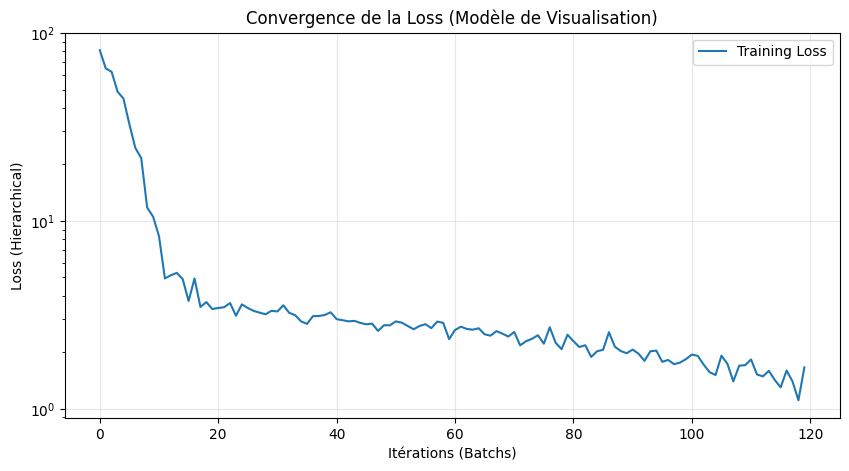

In [93]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title("Convergence de la Loss (Modèle de pour visualisation (peu d'epoch))")
plt.xlabel("Itérations (Batchs)")
plt.ylabel("Loss (Hierarchical)")
plt.yscale("log") 
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

>>> Visualisation des activations sur le TRAIN set


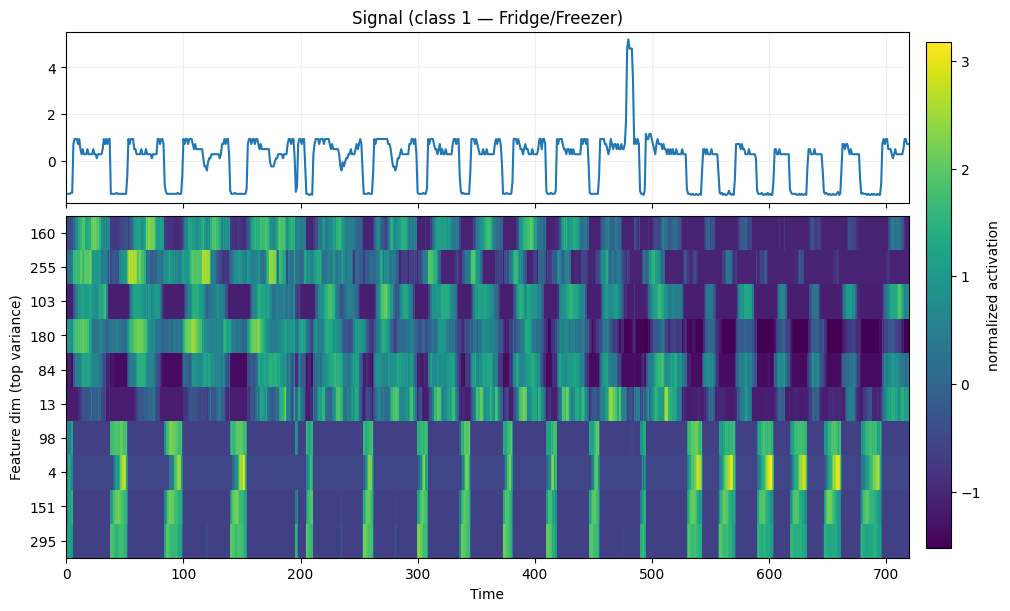

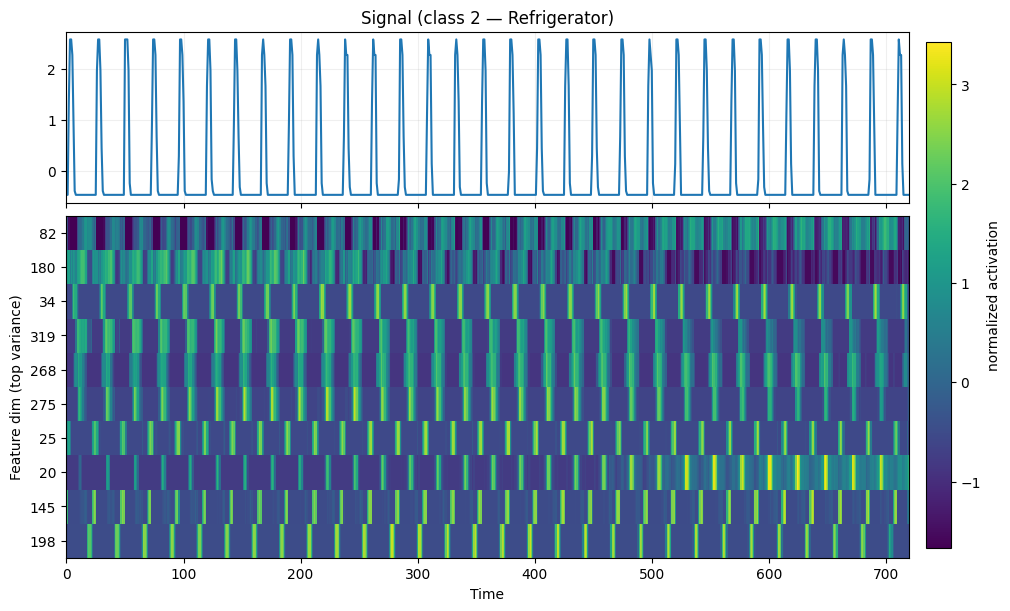


>>> Visualisation des activations sur le TEST set


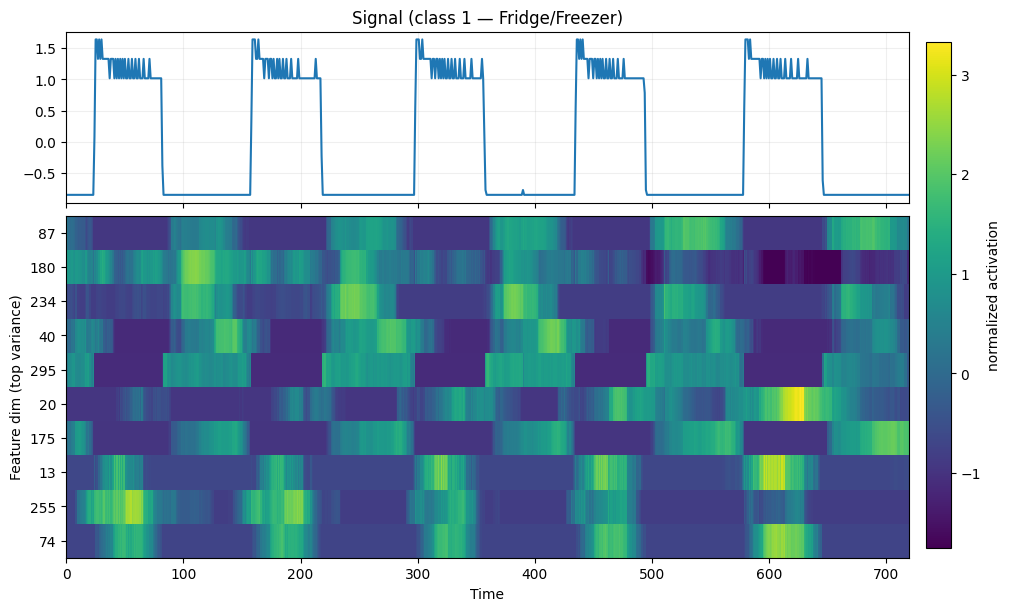

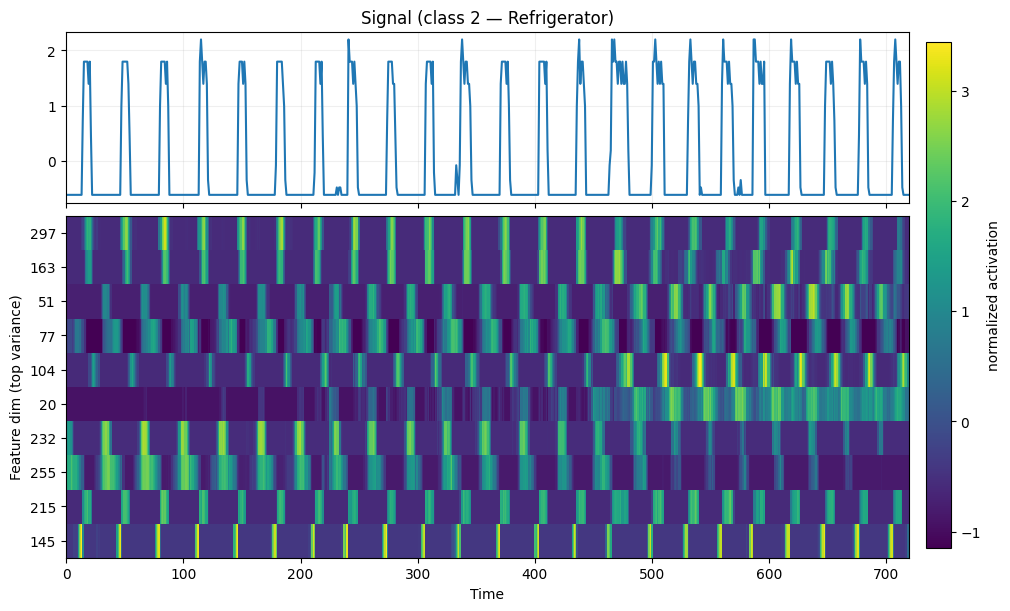

In [94]:


print(">>> Visualisation des activations sur le TRAIN set")
for idx in range(2):  
    visualize_ts2vec_heatmap(
        model=viz_model,
        dataloader=train_viz_loader,
        device=device,
        n_dims=10, # Top 10 dimensions
        sampleidx=idx,
        class_name_map=CLASS_NAMES
    )

print("\n>>> Visualisation des activations sur le TEST set")
for idx in range(2):
    visualize_ts2vec_heatmap(
        model=viz_model,
        dataloader=test_viz_loader,
        device=device,
        n_dims=10,
        sampleidx=idx,
        class_name_map=CLASS_NAMES
    )

## Etude de la Robustesse aux données Manquante

In [95]:
def run_parameter_sweep(mask_probs=None, missing_ratios=None, PREPROCESS=True):
    """
    1. Loop over MASK_PROB.
    2. Train Encoder on CLEAN data.
    3. Train SVM on CLEAN data.
    4. Loop over RATIO_MISSING to evaluate robustness.
    5. IF MASK_PROB == 0.0: Also run Classic Imputation Comparison on this specific model/svm.
    """
    if mask_probs is None:
        mask_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8]
    if missing_ratios is None:
        missing_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8]
    
    # Load data ONCE (Clean)
    X_train_np, y_train_np, X_test_np, y_test_np = load_data(PREPROCESS)
    
    if torch.cuda.is_available(): device = 'cuda:0'
    elif torch.backends.mps.is_available(): device = 'mps'
    else: device = 'cpu'
    print("Device:", device)

    # Setup results directory
    EXP_DIR = create_experiment_dir("RD_CLEAN_TRAIN_ROBUSTNESS")
    
    # Initialize matrix
    results_matrix = np.full((len(mask_probs), len(missing_ratios)), -1.0)
    matrix_path = EXP_DIR / "results_matrix.npy"

    with open(EXP_DIR / "parameters.json", "w") as f:
        json.dump({
            "mask_probs": mask_probs,
            "missing_ratios": missing_ratios,
            "N_EPOCH": N_EPOCH
        }, f, indent=2)

    # MAIN LOOP 
    for i, mask_prob in enumerate(mask_probs):
        print(f"\n{'='*60}")
        print(f"STARTING TRAINING PHASE FOR MASK_PROB = {mask_prob}")
        print(f"{'='*60}")
        
        #Prepare CLEAN Train Dataloader
        X_train_torch = torch.from_numpy(X_train_np).float()
        y_train_torch = torch.from_numpy(y_train_np.astype(np.int64))
        train_dataset_clean = TensorDataset(X_train_torch, y_train_torch)
        
        train_loader = DataLoader(train_dataset_clean, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        train_eval_loader = DataLoader(train_dataset_clean, batch_size=32, shuffle=False)

        # Train Encoder (Clean)
        model = m.Encoder(
            in_channel=1,
            representation_dim=REP_DIM,
            num_blocks=NUM_BLOCKS,
            kernel_size=KERNEL_SIZE,
            mask_prob=mask_prob,
        )
        model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=LR)
        train_model(model, train_loader, optimizer, device, N_EPOCH, ALPHA_HIER)
        
        # 3. Train SVM on Clean Features
        Z_train, y_train = extract_representations(train_eval_loader, model, device)
        best_svm = train_svm_classifier(Z_train, y_train)
        
        # 4. Standard Evaluation: Robustness on Raw Corrupted Data
        # (This corresponds to 'implicit' imputation by the encoder if it can handle it, or just noise)
        for j, missing_ratio in enumerate(missing_ratios):
            test_dataset_corrupted = prepare_dataset_for_test(X_test_np, y_test_np, RATIO_MISSING=missing_ratio)
            test_eval_loader = DataLoader(test_dataset_corrupted, batch_size=32, shuffle=False)
            
            Z_test_corrupted, y_test = extract_representations(test_eval_loader, model, device)
            y_pred_test = best_svm.predict(Z_test_corrupted)
            acc_test = accuracy_score(y_test, y_pred_test)
            
            results_matrix[i, j] = acc_test
        
        np.save(matrix_path, results_matrix)

        # Classic Imputation Comparison (ONLY IF MASK_PROB == 0.0)
        if mask_prob == 0.0:
            print(f"\n>>> Running Classic Imputation Comparison for MaskProb={mask_prob}...")
            
            methods = ['zero', 'mean', 'local_mean', 'linear']
            imputation_results = {m: [] for m in methods}
            
            X_test_torch_clean = torch.from_numpy(X_test_np).float()
            y_test_torch = torch.from_numpy(y_test_np.astype(np.int64))
            
            for method in methods:
                print(f"   Testing method: {method}")
                for ratio in missing_ratios:
                    # A. Inject NaN
                    X_test_corrupted = X_test_torch_clean.clone()
                    for k in range(X_test_corrupted.size(0)):
                        X_test_corrupted[k] = inject_missing_values_random_noise(X_test_corrupted[k], ratio)
                    
                    # B. Apply Imputation
                    X_test_imputed = apply_imputation(X_test_corrupted, method)
                    
                    # C. Dataloader
                    temp_dataset = TensorDataset(X_test_imputed, y_test_torch)
                    temp_loader = DataLoader(temp_dataset, batch_size=32, shuffle=False)
                    
                    # D. Evaluate with SAME Encoder/SVM
                    Z_test_imp, y_test_full = extract_representations(temp_loader, model, device)
                    y_pred_imp = best_svm.predict(Z_test_imp)
                    acc_imp = accuracy_score(y_test_full, y_pred_imp)
                    
                    imputation_results[method].append(float(acc_imp))
            
            # Save imputation results
            imp_json_path = EXP_DIR / "imputation_results_mask0.json"
            with open(imp_json_path, "w") as f:
                json.dump(imputation_results, f, indent=2)
            print(f">>> Imputation results saved to {imp_json_path}")


    # Final Save
    save_results_heatmap(results_matrix, mask_probs, missing_ratios, EXP_DIR)
    
    print(f"\nAll experiments complete!")
    print(f"Results saved to {EXP_DIR}")
    return results_matrix

### Trainning

In [96]:
# PARAMETRES DE L'EXPERIENCE
my_mask_probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
my_missing_ratios = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

matrix_robustness = run_parameter_sweep(
    mask_probs=my_mask_probs,
    missing_ratios=my_missing_ratios,
    PREPROCESS=True
)

using PREPROCESSED data
X_train_np shape: (370, 720, 1)
X_test_np shape: (375, 720, 1)
Device: cuda:0
Created new run: RD_CLEAN_TRAIN_ROBUSTNESS/3

STARTING TRAINING PHASE FOR MASK_PROB = 0.0
[Epoch 1/30] Last batch loss: 1.9567
[Epoch 2/30] Last batch loss: 1.7117
[Epoch 3/30] Last batch loss: 1.3203
[Epoch 4/30] Last batch loss: 1.1203
[Epoch 5/30] Last batch loss: 1.4013
[Epoch 6/30] Last batch loss: 0.8340
[Epoch 7/30] Last batch loss: 1.2410
[Epoch 8/30] Last batch loss: 0.5490
[Epoch 9/30] Last batch loss: 1.3348
[Epoch 10/30] Last batch loss: 0.6998
[Epoch 11/30] Last batch loss: 0.2982
[Epoch 12/30] Last batch loss: 0.3331
[Epoch 13/30] Last batch loss: 0.6660
[Epoch 14/30] Last batch loss: 0.2894
[Epoch 15/30] Last batch loss: 1.2210
[Epoch 16/30] Last batch loss: 0.5866
[Epoch 17/30] Last batch loss: 0.3280
[Epoch 18/30] Last batch loss: 0.2868
[Epoch 19/30] Last batch loss: 0.1736
[Epoch 20/30] Last batch loss: 0.5339
[Epoch 21/30] Last batch loss: 0.4031
[Epoch 22/30] Last 

In [97]:
# RECUPERATION AUTOMATIQUE DU DERNIER RUN 
CURR_DIR = Path.cwd()
RUNS_DIR = CURR_DIR / "runs" / "RD_CLEAN_TRAIN_ROBUSTNESS"

# Trouver le dossier le plus récent (le plus grand ID entier)
if RUNS_DIR.exists():
    subdirs = [d for d in RUNS_DIR.iterdir() if d.is_dir() and d.name.isdigit()]
    if subdirs:
        latest_run_dir = max(subdirs, key=lambda d: int(d.name))
        print(f"Chargement des résultats depuis : {latest_run_dir}")

        # Chargement du JSON d'imputation
        imp_json_path = latest_run_dir / "imputation_results_mask0.json"

        if imp_json_path.exists():
            with open(imp_json_path, "r") as f:
                imputation_data = json.load(f)
            
            imputation_methods = list(imputation_data.keys())
            # Création de la matrice numpy pour l'imputation (Nb Methodes, Nb Ratios)
            matrix_imputation = np.array([imputation_data[m] for m in imputation_methods])
            
            print(f"Méthodes d'imputation chargées : {imputation_methods}")
            print(f"Dimensions matrix_imputation : {matrix_imputation.shape}")
        else:
            print("ATTENTION : Pas de fichier d'imputation trouvé (Avez-vous inclus 0.0 dans mask_probs ?)")
            matrix_imputation = np.zeros((0, 0))
            imputation_methods = []
    else:
        print("Aucun run trouvé.")
else:
    print("Dossier runs non trouvé.")

# Variables nécessaires pour le script de visualisation
mask_probs = my_mask_probs
missing_ratios = my_missing_ratios

Chargement des résultats depuis : /home/infres/kberlivet-23/T2SVEC/src/first_Imple/runs/RD_CLEAN_TRAIN_ROBUSTNESS/3
Méthodes d'imputation chargées : ['zero', 'mean', 'local_mean', 'linear']
Dimensions matrix_imputation : (4, 19)


### visualisation

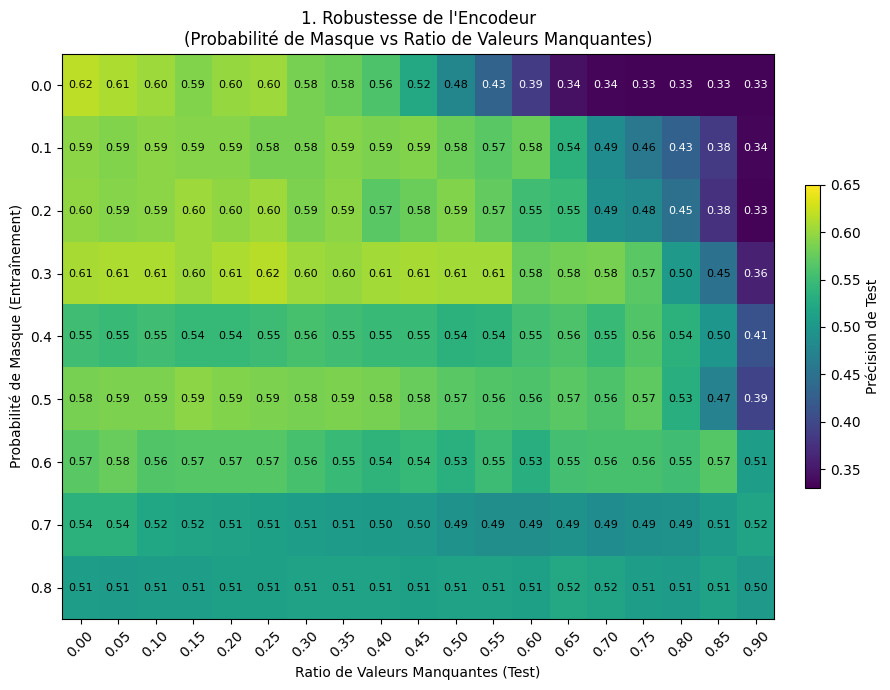

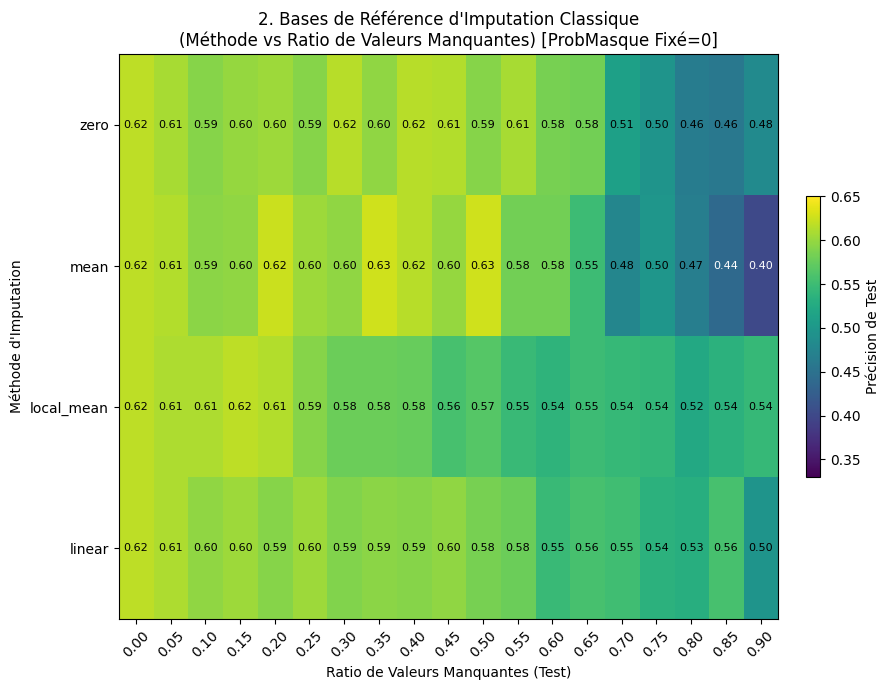

In [99]:
# Echelle de couleur commune pour bien comparer
VMIN, VMAX = 0.33, 0.65

# FIGURE 1 : ROBUSTESSE ENCODEUR 
fig1, ax1 = plt.subplots(figsize=(9, 7))
im1 = ax1.imshow(matrix_robustness, cmap='viridis', aspect='auto', vmin=VMIN, vmax=VMAX)
ax1.set_title("1. Robustesse de l'Encodeur\n(Probabilité de Masque vs Ratio de Valeurs Manquantes)")
ax1.set_xlabel("Ratio de Valeurs Manquantes (Test)")
ax1.set_ylabel("Probabilité de Masque (Entraînement)")
ax1.set_xticks(np.arange(len(missing_ratios)))
ax1.set_xticklabels([f"{r:.2f}" for r in missing_ratios], rotation=45) 
ax1.set_yticks(np.arange(len(mask_probs)))
ax1.set_yticklabels(mask_probs)

for i in range(len(mask_probs)):
    for j in range(len(missing_ratios)):
        val = matrix_robustness[i, j]
        if val != -1:
            color = "white" if val < 0.45 else "black"
            ax1.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)

cbar1 = fig1.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.02, pad=0.04)
cbar1.set_label("Précision de Test")
plt.tight_layout()
plt.show()

# FIGURE 2 : IMPUTATION CLASSIQUE 
if 'matrix_imputation' in locals() and len(imputation_methods) > 0:
    fig2, ax2 = plt.subplots(figsize=(9, 7))
    im2 = ax2.imshow(matrix_imputation, cmap='viridis', aspect='auto', vmin=VMIN, vmax=VMAX)
    ax2.set_title("2. Bases de Référence d'Imputation Classique\n(Méthode vs Ratio de Valeurs Manquantes) [ProbMasque Fixé=0]")
    ax2.set_xlabel("Ratio de Valeurs Manquantes (Test)")
    ax2.set_ylabel("Méthode d'Imputation")
    ax2.set_xticks(np.arange(len(missing_ratios)))
    ax2.set_xticklabels([f"{r:.2f}" for r in missing_ratios], rotation=45)
    ax2.set_yticks(np.arange(len(imputation_methods)))
    ax2.set_yticklabels(imputation_methods)

    # Annotations Figure 2
    for i in range(len(imputation_methods)):
        for j in range(len(missing_ratios)):
            val = matrix_imputation[i, j]
            color = "white" if val < 0.45 else "black"
            ax2.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)

    cbar2 = fig2.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.02, pad=0.04)
    cbar2.set_label("Précision de Test")

    plt.tight_layout()
    plt.show()
else:
    print("Pas de données d'imputation à afficher.")